In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dataToDictionnary import *
import pandas as pd
pd.options.mode.chained_assignment = None

pair = 'SNX/USDT'
exchange = ['binance']
duration = ['3m']
df = oneAssetToDF(pair, duration, exchange)
df['date'] = pd.to_datetime(df['date'],unit='ms')
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88703 entries, 0 to 88702
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    88703 non-null  datetime64[ns]
 1   high    88703 non-null  float64       
 2   low     88703 non-null  float64       
 3   close   88703 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.7 MB
None


In [2]:
def parabolic_sar(df):
    
    #this is common accelerating factors for forex and commodity
    #so i kept them for the moment for crypto currencies
    #i planned to play with them in order to optimize trading algorytm
    initial_af=0.02
    step_af=0.01
    end_af=0.2
    
    
    df['trend']=0
    df['sar']=0.0
    df['real sar']=0.0
    df['ep']=0.0
    df['af']=0.0

    #initial values for recursive calculation
    df.at[1, 'trend']=1 if df['close'][1]>df['close'][0] else -1
    df.at[1, 'sar']=df['high'][0] if df['trend'][1]>0 else df['low'][0]
    df.at[1,'real sar']=df['sar'][1]
    df.at[1, 'ep']=df['high'][1] if df['trend'][1]>0 else df['low'][1]
    df.at[1 , 'af']=initial_af

    #calculation
    for i in range(2,len(df)):
        temp=df['sar'][i-1]+df['af'][i-1]*(df['ep'][i-1]-df['sar'][i-1])
        if df['trend'][i-1]<0:
            df.at[i,'sar']=max(temp,df['high'][i-1],df['high'][i-2])
            temp=1 if df['sar'][i]<df['high'][i] else df['trend'][i-1]-1
        else:
            df.at[i,'sar']=min(temp,df['low'][i-1],df['low'][i-2])
            temp=-1 if df['sar'][i]>df['low'][i] else df['trend'][i-1]+1
        df.at[i,'trend']=temp
    
        
        if df['trend'][i]<0:
            temp=min(df['low'][i],df['ep'][i-1]) if df['trend'][i]!=-1 else df['low'][i]
        else:
            temp=max(df['high'][i],df['ep'][i-1]) if df['trend'][i]!=1 else df['high'][i]
        df.at[i,'ep']=temp
    
    
        if np.abs(df['trend'][i])==1:
            temp=df['ep'][i-1]
            df.at[i,'af']=initial_af
        else:
            temp=df['sar'][i]
            if df['ep'][i]==df['ep'][i-1]:
                df.at[i,'af']=df['af'][i-1]
            else:
                df.at[i,'af']=min(end_af,df['af'][i-1]+step_af)
        df.at[i,'real sar']=temp
       
        
    return df

In [3]:
#generating signals to know when long/short

def signal_generation(df,method):
    
        new=method(df)

        new['positions'],new['signals']=0,0
        new['positions']=np.where(new['real sar']<new['close'],1,0)
        new['signals']=new['positions'].diff()
        
        return new

In [4]:
#i use it to make the strategy easier understandable
def plot(new,ticker):
    
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    
    new['close'].plot(lw=3,label='%s'%ticker)
    new['real sar'].plot(linestyle=':',label='Parabolic SAR',color='k')
    ax.plot(new.loc[new['signals']==1].index,new['close'][new['signals']==1],marker='^',color='g',label='LONG',lw=0,markersize=10)
    ax.plot(new.loc[new['signals']==-1].index,new['close'][new['signals']==-1],marker='v',color='r',label='SHORT',lw=0,markersize=10)
    
    plt.legend()
    plt.grid(True)
    plt.title('Parabolic SAR')
    plt.ylabel('price')
    plt.show()


In [5]:
# compute returns of our strategy
def create_portfolio_returns(df):
    """Creates a portfolio pandas DataFrame which keeps track of
    the account equity and ultimately generates an equity curve.
    This can be used to generate drawdown and risk/reward ratios."""
    
    
    print("Constructing a portfolio...")
    portfolio = pd.DataFrame(index=df.index)
    portfolio['positions'] = df['signals']
    portfolio['close'] =  1*df['close'] * (portfolio['positions']==-1)+df['close']*(portfolio['positions']==1)
    

    # Construct a percentage returns stream and eliminate all 
    # of the NaN and -inf/+inf cells
    print("Constructing the equity curve...")
    portfolio['returns'] = portfolio['close'].pct_change()
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1, 0.0, inplace=True)
    porfolio=portfolio.dropna()
    # Calculate the full equity curve
    portfolio['returns'] = (portfolio['returns']+1.0 ).cumprod()

    return portfolio

                 date   high    low  close
0 2020-07-09 12:00:00  3.398  2.893  3.398
1 2020-07-09 12:03:00  3.372  3.111  3.131
2 2020-07-09 12:06:00  3.279  3.100  3.177
3 2020-07-09 12:09:00  3.189  3.062  3.161
4 2020-07-09 12:12:00  3.170  3.140  3.169
                 date   high    low  close  trend       sar  real sar     ep  \
0 2020-07-09 12:00:00  3.398  2.893  3.398      0  0.000000  0.000000  0.000   
1 2020-07-09 12:03:00  3.372  3.111  3.131     -1  2.893000  2.893000  3.111   
2 2020-07-09 12:06:00  3.279  3.100  3.177     -2  3.398000  3.398000  3.100   
3 2020-07-09 12:09:00  3.189  3.062  3.161     -3  3.389060  3.389060  3.062   
4 2020-07-09 12:12:00  3.170  3.140  3.169     -4  3.375978  3.375978  3.062   

     af  positions  signals  
0  0.00          1      NaN  
1  0.02          1      0.0  
2  0.03          0     -1.0  
3  0.04          0      0.0  
4  0.04          0      0.0  
Constructing a portfolio...
Constructing the equity curve...
return for parabolic

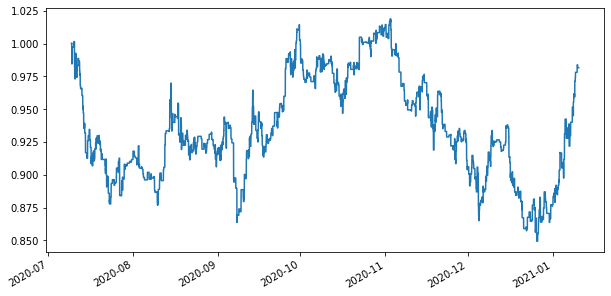

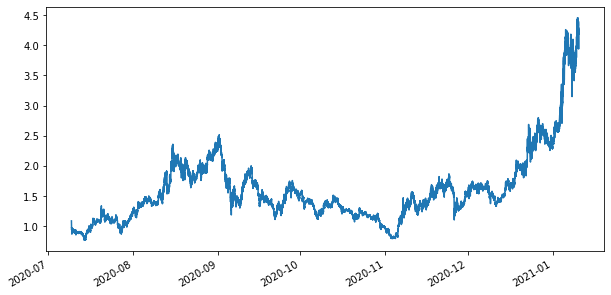

In [6]:
#no need to iterate over timestamp index
df.set_index(df['date'])
print(df.head())

new=signal_generation(df,parabolic_sar)
print(new.head())

portfolio = create_portfolio_returns(new)
print('return for parabolic SAR strategy : ',portfolio.iloc[-1]['returns']*100, '%')
df['buyAndHold']=df['close']/df['close'][1]

fig, ax = plt.subplots(1, figsize = (10,5))
fig.autofmt_xdate()
plt.plot(new['date'], portfolio['returns'])

fig, ax = plt.subplots(1, figsize = (10,5))
fig.autofmt_xdate()
print('return for buy and hold strategy : ', df.iloc[-1]['buyAndHold']*100, '%')
plt.plot(new['date'], df['close']/df["close"][1])

                 date   high    low  close
0 2020-07-09 12:00:00  3.398  2.893  3.398
1 2020-07-09 12:03:00  3.372  3.111  3.131
2 2020-07-09 12:06:00  3.279  3.100  3.177
3 2020-07-09 12:09:00  3.189  3.062  3.161
4 2020-07-09 12:12:00  3.170  3.140  3.169
                  date   high    low  close
0  2020-12-25 00:51:00  7.442  7.370  7.415
1  2020-12-25 00:54:00  7.466  7.394  7.454
2  2020-12-25 00:57:00  7.454  7.428  7.446
3  2020-12-25 01:00:00  7.437  7.407  7.425
4  2020-12-25 01:03:00  7.437  7.396  7.398
..                 ...    ...    ...    ...
95 2020-12-25 06:36:00  7.224  7.205  7.218
96 2020-12-25 06:39:00  7.236  7.201  7.236
97 2020-12-25 06:42:00  7.246  7.223  7.223
98 2020-12-25 06:45:00  7.241  7.201  7.241
99 2020-12-25 06:48:00  7.242  7.219  7.241

[100 rows x 4 columns]
                 date   high    low  close
0 2020-12-25 00:51:00  7.442  7.370  7.415
1 2020-12-25 00:54:00  7.466  7.394  7.454
2 2020-12-25 00:57:00  7.454  7.428  7.446
3 2020-12-25 01:00

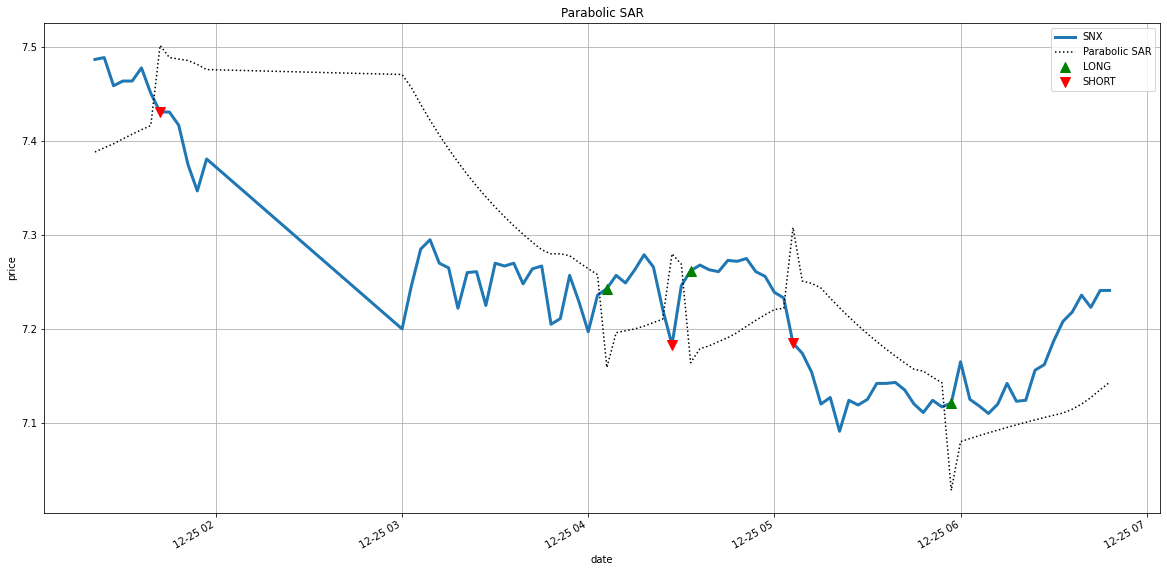

In [7]:

pair = 'SNX/USDT'
ticker = ('SNX')
exchange = ['binance']
duration = ['3m']
df = oneAssetToDF(pair, duration, exchange)
df['date'] = pd.to_datetime(df['date'],unit='ms')
print(df.head())
df = df.iloc[80800:80900]
df = df.reset_index(drop=True)
print(df)
#no need to iterate over timestamp index
df.set_index(df['date'])
print(df.head())
slicer = 10
new=signal_generation(df,parabolic_sar)
print(new)
#so that we get a date x axis
new.set_index(new['date'],inplace=True)

#shorten our plotting horizon and plot
new=new[slicer:]
plot(new,ticker)

In [8]:
import backtrader as bt

class MySignal(bt.Indicator):
    lines = ('signal',)
    params = (('period', 30),)

    def __init__(self):
        self.lines.signal = self.data - bt.indicators.SMA(period=self.p.period)

class PSARStrat(bt.Strategy):

    params = (
        ("period", 2),
        ("af", 0.02),
        ("afmax", 0.2)
        )

    def __init__(self):
        self.psar = bt.indicators.ParabolicSAR(period=self.p.period, af=self.p.af, afmax=self.p.afmax)

    def next(self):
        pass


cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)

cerebro.add_signal(bt.SIGNAL_LONGSHORT, MySignal)
cerebro.broker.setcash(100000.0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Starting Portfolio Value: nan
